# Introduction
## What is mean reversion?
A mean reversion algorithm is a quantitative trading strategy based on the idea that asset prices and returns tend to move back towards their historical average or mean over time. When prices deviate significantly from this average, the algorithm identifies potential buy or sell opportunities, anticipating that prices will revert to the mean.

## Aim

The aim with this project is to develop a successful mean reversion algorithm which beats, or performs similarly, to the S&P 500 index which annually currently returns on average 10.33% (nominal). Development will take an iterative approach, refining previous strategies, datasets and parameters to improve the results yielded from the previous iteration

In [97]:
import yfinance as yf
from curl_cffi import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [98]:
session = requests.Session(impersonate="chrome") # To fix yfinance rate limitter bug
ticker = yf.Ticker("MSFT",session=session)

# Data Cleansing

In [99]:
# msft_historical_data = ticker.history(start='2000-01-01', end='2020-12-01', interval='1d').reset_index()


In [100]:
msft_historical_data = pd.read_csv("msft_00-20.csv")
msft_historical_data = msft_historical_data.drop(columns=["Open","High","Low","Dividends","Stock Splits"]) # Remove unnecessary Columns
msft_historical_data.dropna()

msft_historical_data["Date"] = pd.to_datetime(msft_historical_data["Date"],utc=True)

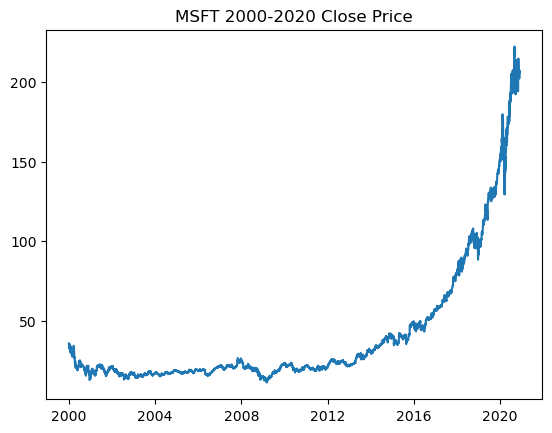

In [101]:
plt.plot(msft_historical_data["Date"],msft_historical_data["Close"])
plt.title("MSFT 2000-2020 Close Price")
plt.show()

# Mean Reversion Algorithm

In [102]:
# Create simple moving average column (2 week)
msft_historical_data["SMA"] = (msft_historical_data["Close"].rolling(14).sum()) / 14
msft_historical_data.dropna()

,Date,Close,Volume,SMA
13,2000-01-21 05:00:00+00:00,31.799646,68416200,33.802869
14,2000-01-24 05:00:00+00:00,31.033401,63597600,33.467632
15,2000-01-25 05:00:00+00:00,31.512310,59823200,33.252807
16,2000-01-26 05:00:00+00:00,30.458708,49365000,32.936726
17,2000-01-27 05:00:00+00:00,30.267136,63654800,32.690429
...,...,...,...,...
5257,2020-11-23 05:00:00+00:00,202.318283,25683500,207.117443
5258,2020-11-24 05:00:00+00:00,205.929214,33979700,206.982293
5259,2020-11-25 05:00:00+00:00,205.938812,21012900,206.374488
5260,2020-11-27 05:00:00+00:00,207.248428,14512200,205.830729


In [103]:
# Create standard deviation column over 2 week
msft_historical_data["Std_deviation"] = msft_historical_data["Close"].rolling(14).std()

In [104]:
msft_historical_data["Buy/Sell"] = np.where(msft_historical_data["Close"] > msft_historical_data["SMA"] + (msft_historical_data["Std_deviation"] * 2),"Sell",
                                            np.where(msft_historical_data["Close"] < msft_historical_data["SMA"] - (msft_historical_data["Std_deviation"] * 2),"Buy","Neither" ))
msft_historical_data = msft_historical_data.dropna()

In [105]:
# msft_historical_data_reversed = msft_historical_data[::-1] # Reverse to find the best buy/Sell price in future

# Returns

In [106]:
def calculateGain(row, df:pd.DataFrame):
    indexesOfNextFiveDays = row.name + 5 # row.name = row's index
    if indexesOfNextFiveDays < len(df):
        prices = df.iloc[row.name:indexesOfNextFiveDays]

        if row["Buy/Sell"] == "Buy":
            bestPrice = np.max(prices["Close"])
            exit = ((bestPrice - row["Close"]) / row["Close"]) * 100
            if exit < 0:
                return exit
            else:
                return exit
            
        elif row["Buy/Sell"] == "Sell":
            bestPrice = np.min(prices["Close"])
            exit = ((bestPrice - row["Close"]) / row["Close"]) * 100
            if exit < 0:
                return exit
            else:
                return exit
            
        else:
            return 0
        
    else:
        return None

In [107]:
msft_historical_data["Gain/Loss"] = msft_historical_data.apply(calculateGain, axis=1, args=(msft_historical_data,)) # Trailing comma makes it a tuple - required

In [108]:
display(msft_historical_data)

,Date,Close,Volume,SMA,Std_deviation,Buy/Sell,Gain/Loss
13,2000-01-21 05:00:00+00:00,31.799646,68416200,33.802869,1.173417,Neither,0.0
14,2000-01-24 05:00:00+00:00,31.033401,63597600,33.467632,1.249467,Neither,0.0
15,2000-01-25 05:00:00+00:00,31.512310,59823200,33.252807,1.311640,Neither,0.0
16,2000-01-26 05:00:00+00:00,30.458708,49365000,32.936726,1.417289,Neither,0.0
17,2000-01-27 05:00:00+00:00,30.267136,63654800,32.690429,1.563637,Neither,0.0
...,...,...,...,...,...,...,...
5257,2020-11-23 05:00:00+00:00,202.318283,25683500,207.117443,4.030430,Neither,NaN
5258,2020-11-24 05:00:00+00:00,205.929214,33979700,206.982293,4.036731,Neither,NaN
5259,2020-11-25 05:00:00+00:00,205.938812,21012900,206.374488,3.419585,Neither,NaN
5260,2020-11-27 05:00:00+00:00,207.248428,14512200,205.830729,2.427706,Neither,NaN


In [109]:
msft_historical_data[msft_historical_data["Buy/Sell"] != "Neither"]

,Date,Close,Volume,SMA,Std_deviation,Buy/Sell,Gain/Loss
46,2000-03-09 05:00:00+00:00,30.650269,88198800,28.668950,0.847914,Sell,-9.125012
47,2000-03-10 05:00:00+00:00,30.956766,85589000,28.798940,1.042372,Sell,-12.314349
56,2000-03-23 05:00:00+00:00,34.289978,148224000,30.180934,1.620722,Sell,-33.743010
57,2000-03-24 05:00:00+00:00,34.232525,112196800,30.642057,1.793284,Sell,-33.631810
77,2000-04-24 04:00:00+00:00,20.420746,313645800,24.813037,1.911503,Buy,4.315205
...,...,...,...,...,...,...,...
5196,2020-08-27 04:00:00+00:00,217.607819,57602200,203.869862,5.814981,Sell,-11.558840
5197,2020-08-28 04:00:00+00:00,219.845505,26292900,205.321587,7.051397,Sell,-12.459033
5227,2020-10-12 04:00:00+00:00,212.632919,40461400,201.079985,4.937389,Sell,-8.613372
5228,2020-10-13 04:00:00+00:00,214.035126,28950800,202.607711,5.413348,Sell,-9.212073


In [110]:
totalReturn = msft_historical_data["Gain/Loss"].sum()
print("Total Return: ", totalReturn,"%")

Total Return:  125.45123433056568 %


# Visualise Returns

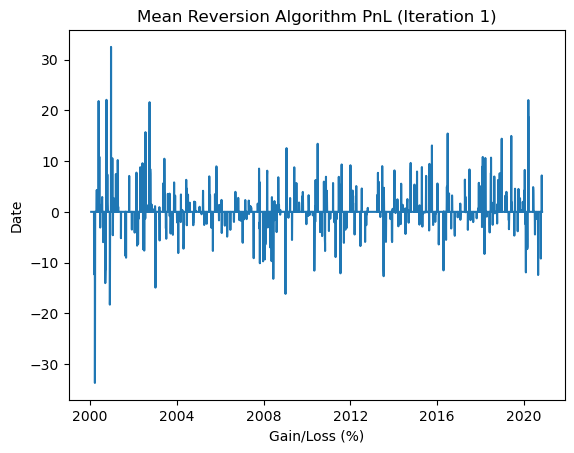

In [111]:
plt.plot(msft_historical_data["Date"],msft_historical_data["Gain/Loss"])
plt.ylabel("Date")
plt.xlabel("Gain/Loss (%)")
plt.title("Mean Reversion Algorithm PnL (Iteration 1)")
plt.show()

## YoY Returns

In [115]:
first_recorded_year = msft_historical_data["Date"].dt.year.min()
most_recent_year = msft_historical_data["Date"].dt.year.max()

current_year = first_recorded_year
while (current_year <= most_recent_year):
    current_year_data = msft_historical_data[msft_historical_data["Date"].dt.year == current_year]
    num_trades_placed = current_year_data[current_year_data["Buy/Sell"] != "Neither"].shape[0]

    print ("Year: ",current_year)
    print("Annual Return", current_year_data["Gain/Loss"].sum())
    print("# of Trades Placed: ", num_trades_placed)
    print("\n")

    current_year += 1

print("\nAverage YoY Return: ", totalReturn / 20)

Year:  2000
Annual Return -37.8083235391008
# of Trades Placed:  24


Year:  2001
Annual Return -6.949152647043313
# of Trades Placed:  14


Year:  2002
Annual Return 74.50016779149765
# of Trades Placed:  26


Year:  2003
Annual Return -10.540653240847918
# of Trades Placed:  23


Year:  2004
Annual Return -8.484199922120796
# of Trades Placed:  24


Year:  2005
Annual Return 41.60098006692114
# of Trades Placed:  30


Year:  2006
Annual Return -11.830597455753674
# of Trades Placed:  18


Year:  2007
Annual Return -42.29258798819014
# of Trades Placed:  23


Year:  2008
Annual Return -42.65138319417824
# of Trades Placed:  26


Year:  2009
Annual Return -1.7279900037621339
# of Trades Placed:  16


Year:  2010
Annual Return -17.681406686686994
# of Trades Placed:  28


Year:  2011
Annual Return -22.80297262676937
# of Trades Placed:  19


Year:  2012
Annual Return 29.227283822044832
# of Trades Placed:  20


Year:  2013
Annual Return -6.3077633436871
# of Trades Placed:  20


Year:  

# Iteration 1: Results summary
- The mean reversion algo was applied to Microsoft (MSFT) from 2000-2020.
- The total return across that 20-year period was 125.45% with a 6.27% average yearly return
- On average, 22 trades were placed per year
- 2018 was the most profitable year with a 91.1% return
- 2007 was the least profitable year with a loss of -42.7% - potentially partially attributed to the GFC